Importing Libraries

In [1]:
import pandas as pd
from matplotlib.pyplot import hist
import matplotlib.pyplot as plt
import numpy as np

Loading date into dataframes

In [2]:
install = pd.read_csv('data\\installs.csv')
adspend = pd.read_csv('data\\adspend.csv')
payout = pd.read_csv('data\\payouts.csv')
revenue = pd.read_csv('data\\revenue.csv')

Data Validation

install null values:  False
adspend null values:  False
payout null values:  False
revenue null values:  False
adspend number of negatives:  0 , zeros:  56
payout number of negatives:  0 , zeros:  0
revenue number of negatives:  63689 , zeros:  98


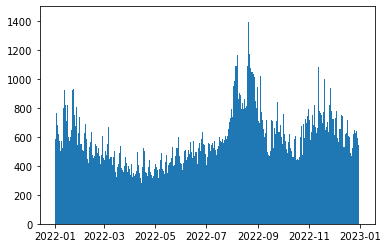

In [3]:
# check out for null values
print('install null values: ',install.isnull().values.any())
print('adspend null values: ',adspend.isnull().values.any())
print('payout null values: ',payout.isnull().values.any())
print('revenue null values: ',revenue.isnull().values.any())
# check if there are any zeros or negatives in price columns
print('adspend number of negatives: ',adspend[adspend['value_usd']<0]['value_usd'].count(),', zeros: ',
      adspend[adspend['value_usd']==0]['value_usd'].count())
print('payout number of negatives: ',payout[payout['value_usd']<0]['value_usd'].count(),', zeros: ',
      payout[payout['value_usd']==0]['value_usd'].count())
print('revenue number of negatives: ',revenue[revenue['value_usd']<0]['value_usd'].count(),', zeros: ',
      revenue[revenue['value_usd']==0]['value_usd'].count())
# check if data is consistant
install_per_day = install.groupby('event_date')['install_id'].count().reset_index()
install_per_day['event_date'] = install_per_day['event_date'].astype("datetime64")
hist(install_per_day['event_date'],weights=install_per_day['install_id'],bins=365)
plt.show()

In [4]:
# deleting negative prices in revenue table
revenue = revenue[revenue['value_usd']>=0]

Financial KPIs

In [5]:
# adding daily costs and revenue to a table to track financial KPIs
finance = revenue.groupby('event_date')['value_usd'].sum().reset_index()
finance.rename(columns={'value_usd':'revenue'},inplace=True)
finance = pd.merge(finance,payout.groupby('event_date')['value_usd'].sum().reset_index(),on='event_date')
finance.rename(columns={'value_usd':'payout'},inplace=True)
finance = pd.merge(finance,adspend.groupby('event_date')['value_usd'].sum().reset_index(),on='event_date')
finance.rename(columns={'value_usd':'adspend'},inplace=True)

In [6]:
# daily cost equals to payouts + adspends
finance['cost'] = finance['payout'] + finance['adspend']
finance['PC1'] = finance['revenue'] - finance['cost']
finance['margin'] = finance['PC1'] / finance['revenue']
# to have better idea of what has been our main cost during the time
finance['adspend_share_of_cost'] = finance['adspend'] * 100 / finance['cost']
# to track everything monthly
finance['month_year'] = finance['event_date'].str[:7]
# finance dataframe is ready for plots
finance

,event_date,revenue,payout,adspend,cost,PC1,margin,adspend_share_of_cost,month_year
0,2022-01-01,419.015757,1.143926,786.499993,787.643919,-368.628162,-0.879748,99.854766,2022-01
1,2022-01-02,616.019842,14.270760,1088.482990,1102.753750,-486.733908,-0.790127,98.705898,2022-01
2,2022-01-03,1005.264356,21.508074,805.581995,827.090069,178.174287,0.177241,97.399549,2022-01
3,2022-01-04,1006.449233,32.137488,748.925995,781.063483,225.385750,0.223941,95.885419,2022-01
4,2022-01-05,917.651720,71.051535,732.239995,803.291530,114.360190,0.124623,91.154950,2022-01
...,...,...,...,...,...,...,...,...,...
360,2022-12-27,858.463275,168.783580,656.968997,825.752577,32.710698,0.038104,79.560030,2022-12
361,2022-12-28,1027.358149,80.717956,621.997999,702.715955,324.642194,0.315997,88.513431,2022-12
362,2022-12-29,630.172810,114.731120,429.375002,544.106122,86.066688,0.136576,78.913834,2022-12
363,2022-12-30,967.483585,104.280799,552.793005,657.073804,310.409781,0.320842,84.129515,2022-12


Important KPIs

In [7]:
# first lets look up revenue per install as a measure to find high potentials
revenue_in_details = pd.merge(revenue, install,on='install_id')
network_revenue = revenue_in_details.groupby('network_id').agg({'install_id':'count','value_usd':'sum'}).reset_index()
network_revenue['revenue_per_install'] = network_revenue['value_usd'] / network_revenue['install_id']

In [8]:
app_revenue = revenue_in_details.groupby('app_id').agg({'install_id':'count','value_usd':'sum'}).reset_index()
app_revenue['revenue_per_install'] = app_revenue['value_usd'] / app_revenue['install_id']

In [9]:
country_revenue = revenue_in_details.groupby('country_id').agg({'install_id':'count','value_usd':'sum'}).reset_index()
country_revenue['revenue_per_install'] = country_revenue['value_usd'] / country_revenue['install_id']

assumption

In [10]:
# all client ids in adspend table are in app ids in app revenue table.
# this can leads us to the point that clients are some of our apps that we decide to advertise for them
print(np.isin(adspend['client_id'].unique(),app_revenue['app_id'].unique()))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]


In [11]:
# so lets compare the cost and revenue for every app/client that have had advertisements
app_cost = adspend.groupby('client_id')['value_usd'].sum().reset_index()
app_comparison = pd.merge(app_cost,app_revenue,left_on='client_id',right_on='app_id')
app_comparison.rename(columns={'value_usd_x':'cost','value_usd_y':'revenue','install_id':'# installs'},inplace=True)
app_comparison['cost per revenue'] = app_comparison['cost'] * 100 / app_comparison['revenue']

payout in details

In [12]:
payout_in_details = pd.merge(payout,install,on='install_id')
payout_in_apps = payout_in_details.groupby('app_id').agg({'install_id':'nunique','value_usd':'sum'}).reset_index()
payout_in_apps = pd.merge(payout_in_apps,app_revenue,on='app_id')
payout_in_apps.rename(columns={'install_id_x':'installs with payout','value_usd_x':'payout',
                              'install_id_y':'total installs','value_usd_y':'revenue'},inplace=True)
payout_in_apps['payout_per_install'] = payout_in_apps['installs with payout'] / payout_in_apps['total installs']
payout_in_apps['payout_per_revenue'] = payout_in_apps['payout'] / payout_in_apps['revenue']

Export excel files to visualize

In [13]:
# extract all ready files for visualization
with pd.ExcelWriter('output.xlsx') as writer:
    finance.to_excel(writer, sheet_name='financial_state')
    network_revenue.to_excel(writer, sheet_name='network_revenue')
    app_revenue.to_excel(writer, sheet_name='app_revenue')
    country_revenue.to_excel(writer, sheet_name='country_revenue')
    app_comparison.to_excel(writer, sheet_name='app_comparison')
    payout_in_apps.to_excel(writer, sheet_name='payout_in_apps')